# Credit Scoring Model Development

## Project Overview

This notebook documents the end-to-end development of a credit scoring model using Lending Club loan data. The goal is to predict loan default probability and generate credit scores that can be used for lending decisions.

## What We'll Cover

1. **Exploratory Data Analysis (EDA)**
   - Dataset overview and structure
   - Target variable distribution (loan status)
   - Feature distributions and outlier detection
   - Correlation analysis
   - Missing value assessment

2. **Feature Engineering**
   - Creating derived features:
     - `loan_to_income` - Loan amount relative to annual income
     - `installment_to_income` - Monthly payment relative to monthly income
     - `credit_history_months` - Length of credit history from earliest credit line
   - Feature transformation and encoding

3. **Weight of Evidence (WoE) Transformation**
   - Optimal binning with monotonic constraints
   - Converting continuous features to WoE values
   - Information Value (IV) calculation for feature selection

4. **Train/Test Split & Class Imbalance Handling**
   - Stratified train/test split
   - SMOTE (Synthetic Minority Over-sampling Technique) for handling imbalanced classes

5. **Model Training**
   - Logistic Regression with class weights
   - Model comparison and selection
   - Hyperparameter considerations

6. **Model Evaluation**
   - ROC-AUC score
   - Confusion matrix
   - Classification report (precision, recall, F1-score)
  

7. **Scorecard Creation**
   - Converting log-odds to credit scores
   - Defining score range 
   - Points-per-feature calculation
   - Score interpretation and risk levels

8. **Model Artifacts Export**
   - Saving trained model (`credit_model.pkl`)
   - Saving WoE transformer (`woe_transformer.pkl`)
   - Saving model configuration (`model_config.pkl`)
   - Saving scorecard table (`scorecard.pkl`)

## Final Model Summary

| Metric | Value |
|--------|-------|
| Algorithm | Logistic Regression |
| Class Weights | Balance / SMOTE |
| AUC Score |  |
| Score Range | |
| Features Used |  |



In [5]:
import pandas as pd

In [6]:
data = pd.read_csv('/Users/azi/Downloads/loan.csv')
data.head()

/var/folders/41/16hhckyx7cd7qrkjm7pdqywr0000gn/T/ipykernel_1084/515010664.py:1: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/azi/Downloads/loan.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [8]:
data.describe(include='all')

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
count,0.0,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2260668,2.260668e+06,2.260668e+06,2260668,2260668,...,10613.000000,10613.000000,2260668,2260668,33056,33056,33056,33056.000000,33056.000000,33056.000000
unique,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7,35,...,NaN,NaN,2,2,82,3,89,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,36 months,NaN,NaN,B,C1,...,NaN,NaN,Cash,N,Feb-2019,ACTIVE,Jan-2019,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,1609754,NaN,NaN,663557,145903,...,NaN,NaN,2182546,2227612,2730,14811,1725,NaN,NaN,NaN
mean,NaN,NaN,1.504693e+04,1.504166e+04,1.502344e+04,NaN,1.309291e+01,4.458076e+02,NaN,NaN,...,11628.036442,193.606331,NaN,NaN,NaN,NaN,NaN,5030.606922,47.775600,13.148596
std,NaN,NaN,9.190245e+03,9.188413e+03,9.192332e+03,NaN,4.832114e+00,2.671737e+02,NaN,NaN,...,7615.161123,198.694368,NaN,NaN,NaN,NaN,NaN,3692.027842,7.336379,8.192319
min,NaN,NaN,5.000000e+02,5.000000e+02,0.000000e+00,NaN,5.310000e+00,4.930000e+00,NaN,NaN,...,55.730000,0.010000,NaN,NaN,NaN,NaN,NaN,44.210000,0.200000,0.000000
25%,NaN,NaN,8.000000e+03,8.000000e+03,8.000000e+03,NaN,9.490000e+00,2.516500e+02,NaN,NaN,...,5628.730000,43.780000,NaN,NaN,NaN,NaN,NaN,2227.000000,45.000000,6.000000
50%,NaN,NaN,1.290000e+04,1.287500e+04,1.280000e+04,NaN,1.262000e+01,3.779900e+02,NaN,NaN,...,10044.220000,132.890000,NaN,NaN,NaN,NaN,NaN,4172.855000,45.000000,14.000000
75%,NaN,NaN,2.000000e+04,2.000000e+04,2.000000e+04,NaN,1.599000e+01,5.933200e+02,NaN,NaN,...,16114.940000,284.180000,NaN,NaN,NaN,NaN,NaN,6870.782500,50.000000,18.000000


In [9]:
#check for missing data
data.isnull().sum()

id                       2260668
member_id                2260668
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
                          ...   
settlement_status        2227612
settlement_date          2227612
settlement_amount        2227612
settlement_percentage    2227612
settlement_term          2227612
Length: 145, dtype: int64

In [10]:
data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,NaN,NaN,12000,12000,12000.0,60 months,14.08,279.72,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260664,NaN,NaN,12000,12000,12000.0,60 months,25.82,358.01,E,E4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260665,NaN,NaN,10000,10000,10000.0,36 months,11.99,332.10,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260666,NaN,NaN,12000,12000,12000.0,60 months,21.45,327.69,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import sys
sys.path.insert(0, '..')
from src.loader import preprocess_loan_data, load_raw_data

In [12]:
#let's load raw data and preprocess it
raw_data = load_raw_data('/Users/azi/Downloads/loan.csv', nrows=50000)

df , preprocessor = preprocess_loan_data(raw_data)

2026-01-17 18:05:14.644 | INFO     | src.data.loader:load_raw_data:28 - Loading data from /Users/azi/Downloads/loan.csv
2026-01-17 18:05:14.951 | INFO     | src.data.loader:load_raw_data:37 - Loaded 50,000 rows, 145 columns
2026-01-17 18:05:14.952 | INFO     | src.data.preprocessor:fit:200 - Fitted preprocessor: 75 features
2026-01-17 18:05:14.969 | INFO     | src.data.preprocessor:transform:220 - Dropped 69 columns
2026-01-17 18:05:14.984 | INFO     | src.data.preprocessor:_create_binary_target:264 - Excluded 113 rows with ambiguous loan status
2026-01-17 18:05:14.985 | INFO     | src.data.preprocessor:_create_binary_target:266 - Target distribution - Default: 143 (0.3%), Good: 49744 (99.7%)


In [13]:
#check result
print(f"shape : {df.shape}")
print(f"Default rate: {df['default'].mean():.1%}")
df.head()

shape : (49887, 79)
Default rate: 0.3%


,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,default,emp_length_numeric,credit_history_months
0,2500,36.0,13.56,84.92,C,10+ years,RENT,55000.0,Not Verified,Dec-2018,...,0.0,1,60124,16901,36500,18124,Cash,0,10.0,215.100000
1,30000,60.0,18.94,777.23,D,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,...,0.0,1,372872,99468,15000,94072,Cash,0,10.0,383.533333
2,5000,36.0,17.97,180.69,D,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,...,0.0,0,136927,11749,13800,10000,Cash,0,6.0,93.366667
3,4000,36.0,18.94,146.51,D,10+ years,MORTGAGE,92000.0,Source Verified,Dec-2018,...,100.0,0,385183,36151,5000,44984,Cash,0,10.0,156.200000
4,30000,60.0,16.14,731.78,C,10+ years,MORTGAGE,57250.0,Not Verified,Dec-2018,...,0.0,0,157548,29674,9300,32332,Cash,0,10.0,219.133333


column_dictionary can be found in: [data](../data/processed/dataDictionary.MD)

In [14]:
df['dti'].value_counts()

dti
17.93     98
0.00      54
13.20     36
12.00     35
14.88     35
          ..
347.77     1
64.20      1
38.27      1
61.99      1
0.49       1
Name: count, Length: 5147, dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49887 entries, 0 to 49999
Data columns (total 79 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   49887 non-null  int64  
 1   term                        49887 non-null  float64
 2   int_rate                    49887 non-null  float64
 3   installment                 49887 non-null  float64
 4   grade                       49887 non-null  object 
 5   emp_length                  49887 non-null  object 
 6   home_ownership              49887 non-null  object 
 7   annual_inc                  49887 non-null  float64
 8   verification_status         49887 non-null  object 
 9   issue_d                     49887 non-null  object 
 10  loan_status                 49887 non-null  object 
 11  purpose                     49887 non-null  object 
 12  addr_state                  49887 non-null  object 
 13  dti                         49887 no

In [16]:
df['loan_status'].value_counts()

loan_status
Current               48708
Fully Paid             1036
Late (31-120 days)       86
Late (16-30 days)        54
Charged Off               3
Name: count, dtype: int64

In [17]:
#save df to csv
df.to_csv('/Users/azi/Downloads/cashi_project/data/processed/processed_loan_data.csv', index=False)

In [18]:
#Class imbalance
print(f"Default rate: {df['default'].mean():.2%}")
print(f"Class ratio: 1:{int((1-df['default'].mean())/df['default'].mean())}")
df['default'].value_counts()

Default rate: 0.29%
Class ratio: 1:347


default
0    49744
1      143
Name: count, dtype: int64

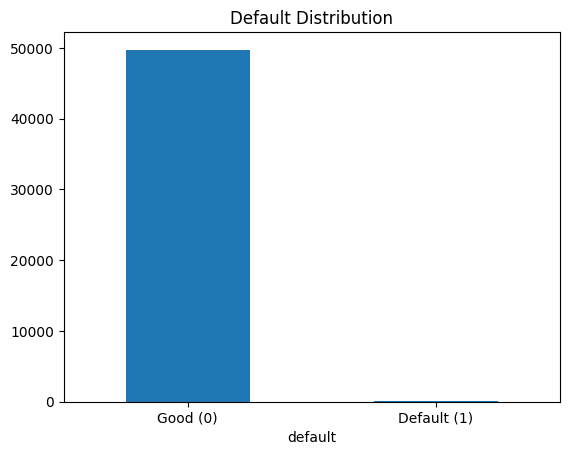

In [19]:
# Target distribution plot
import matplotlib.pyplot as plt
df['default'].value_counts().plot(kind='bar')
plt.title('Default Distribution')
plt.xticks([0,1], ['Good (0)', 'Default (1)'], rotation=0)
plt.show()

The data is highly imbalanced, with a ratio of 97:3 of Good:Bad

In [20]:
# Cell: Numeric feature distributions
df.select_dtypes(include='number').describe()

,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,emp_length_numeric,credit_history_months
count,49887.000000,49887.000000,49887.000000,49887.000000,4.988700e+04,49887.000000,49887.000000,49887.000000,49887.000000,49887.000000,...,49887.000000,49887.000000,49887.000000,4.988700e+04,4.988700e+04,49887.000000,4.988700e+04,49887.000000,49887.000000,49887.000000
mean,15819.826307,43.541524,12.990924,458.454175,8.304893e+04,19.719395,0.238078,0.472267,11.535049,0.120893,...,94.582170,32.791489,0.120753,1.889496e+05,5.396438e+04,27402.610400,4.739890e+04,0.002866,5.904665,194.985572
std,10173.361895,11.141117,4.905022,285.580927,1.007948e+05,17.981872,0.765115,0.758458,5.959764,0.331917,...,9.025615,34.751884,0.331636,1.964344e+05,5.684500e+04,26546.941798,5.014425e+04,0.053463,3.823196,96.253431
min,1000.000000,36.000000,6.000000,30.640000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.500000,37.533333
25%,8000.000000,36.000000,8.810000,249.080000,4.800000e+04,11.790000,0.000000,0.000000,7.000000,0.000000,...,92.300000,0.000000,0.000000,5.330000e+04,2.035200e+04,10000.000000,1.526500e+04,0.000000,2.000000,134.933333
50%,13300.000000,36.000000,11.800000,378.060000,7.000000e+04,17.930000,0.000000,0.000000,10.000000,0.000000,...,100.000000,25.000000,0.000000,1.176470e+05,3.884200e+04,19700.000000,3.500000e+04,0.000000,6.000000,175.533333
75%,21000.000000,60.000000,16.140000,620.020000,1.000000e+05,25.170000,0.000000,1.000000,14.000000,0.000000,...,100.000000,50.000000,0.000000,2.746200e+05,6.883550e+04,36000.000000,6.423700e+04,0.000000,10.000000,241.433333
max,40000.000000,60.000000,30.840000,1618.240000,9.000000e+06,999.000000,21.000000,5.000000,66.000000,5.000000,...,100.000000,100.000000,5.000000,9.792792e+06,2.622906e+06,584200.000000,2.118996e+06,1.000000,10.000000,839.033333


In [21]:
# Cell: Correlation with target (top 15)
corr = df.select_dtypes(include='number').corr()['default'].drop('default')
corr.abs().sort_values(ascending=False).head(15)


int_rate                      0.036078
inq_last_6mths                0.023465
mo_sin_old_il_acct            0.016400
term                          0.015294
num_il_tl                     0.012123
num_actv_rev_tl               0.012106
mths_since_recent_inq         0.012090
chargeoff_within_12_mths      0.012051
num_rev_tl_bal_gt_0           0.011945
tot_cur_bal                   0.011699
tot_hi_cred_lim               0.011557
num_actv_bc_tl                0.011532
total_il_high_credit_limit    0.011483
avg_cur_bal                   0.011429
mort_acc                      0.011040
Name: default, dtype: float64

In [22]:
# Setup
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

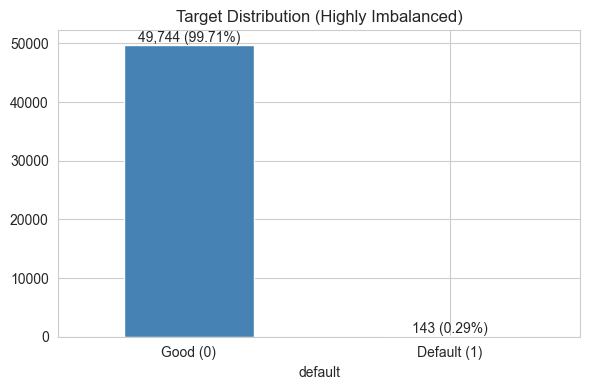

In [23]:
# Cell: Target distribution
fig, ax = plt.subplots(figsize=(6, 4))
df['default'].value_counts().plot(kind='bar', color=['steelblue', 'coral'], ax=ax)
ax.set_title('Target Distribution (Highly Imbalanced)')
ax.set_xticklabels(['Good (0)', 'Default (1)'], rotation=0)
for i, v in enumerate(df['default'].value_counts()):
    ax.text(i, v + 500, f'{v:,} ({v/len(df)*100:.2f}%)', ha='center')
plt.tight_layout()
plt.show()

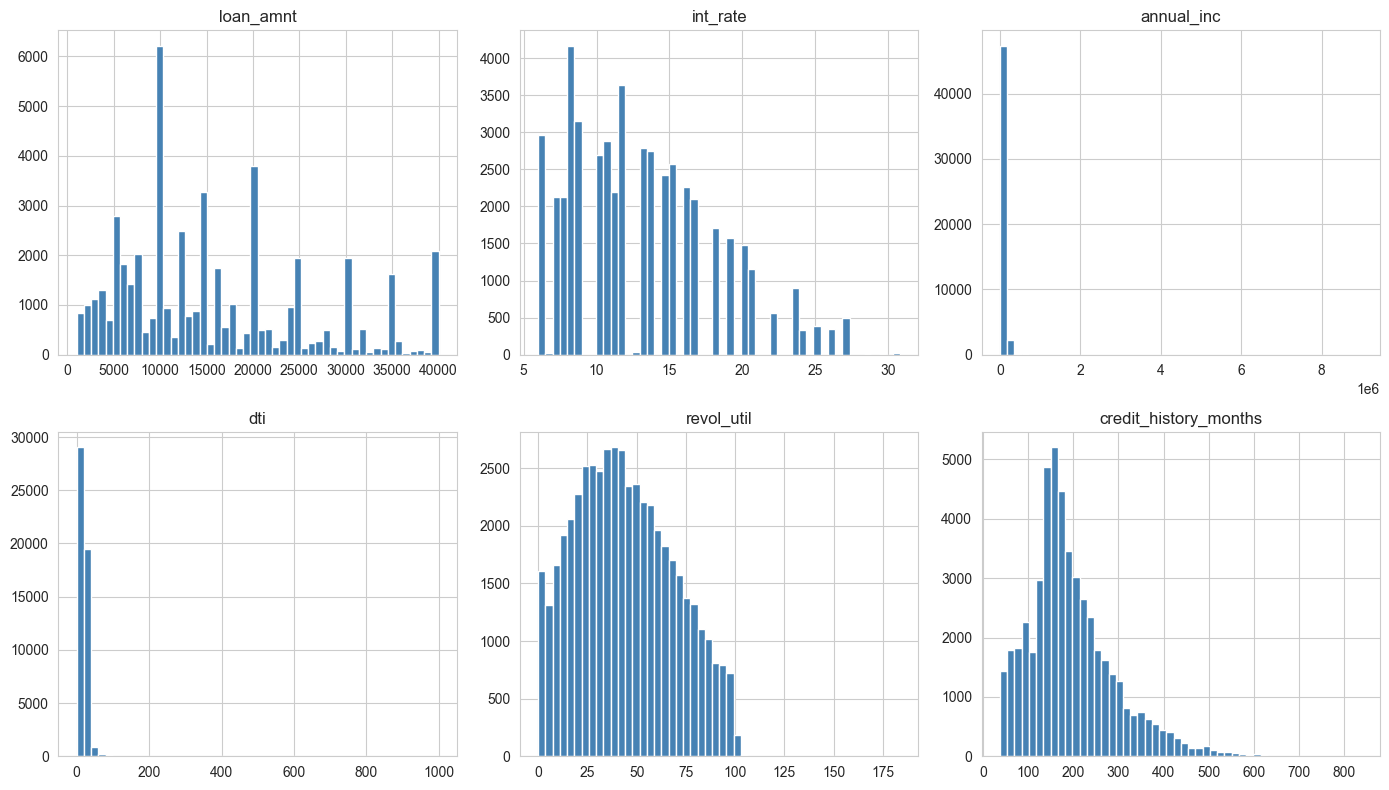

In [24]:
# Cell: Numeric distributions (key features)
key_numeric = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util', 'credit_history_months']
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ax, col in zip(axes.flatten(), key_numeric):
    df[col].hist(bins=50, ax=ax, color='steelblue', edgecolor='white')
    ax.set_title(col)
plt.tight_layout()
plt.show()

In [25]:
df["annual_inc"].value_counts()

annual_inc
60000.0     1949
50000.0     1648
65000.0     1509
80000.0     1462
70000.0     1429
            ... 
259000.0       1
49017.0        1
123720.0       1
12444.0        1
31085.0        1
Name: count, Length: 4507, dtype: int64

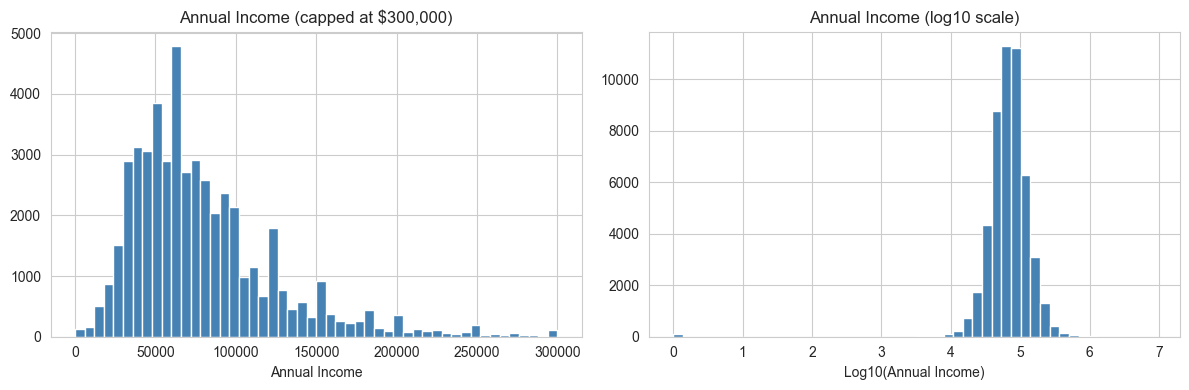

In [26]:
import numpy as np
# Cell: Annual income distribution (capped at 99th percentile)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Raw distribution (capped)
cap = df['annual_inc'].quantile(0.99)
df[df['annual_inc'] <= cap]['annual_inc'].hist(bins=50, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title(f'Annual Income (capped at ${cap:,.0f})')
axes[0].set_xlabel('Annual Income')

# Right: Log scale (full data)
df['annual_inc'].apply(lambda x: np.log10(x + 1)).hist(bins=50, ax=axes[1], color='steelblue', edgecolor='white')
axes[1].set_title('Annual Income (log10 scale)')
axes[1].set_xlabel('Log10(Annual Income)')

plt.tight_layout()
plt.show()

In [27]:
# Cell: Income summary
print(f"Min: ${df['annual_inc'].min():,.0f}")
print(f"Median: ${df['annual_inc'].median():,.0f}")
print(f"Mean: ${df['annual_inc'].mean():,.0f}")
print(f"99th percentile: ${df['annual_inc'].quantile(0.99):,.0f}")
print(f"Max: ${df['annual_inc'].max():,.0f}")

Min: $0
Median: $70,000
Mean: $83,049
99th percentile: $300,000
Max: $9,000,000


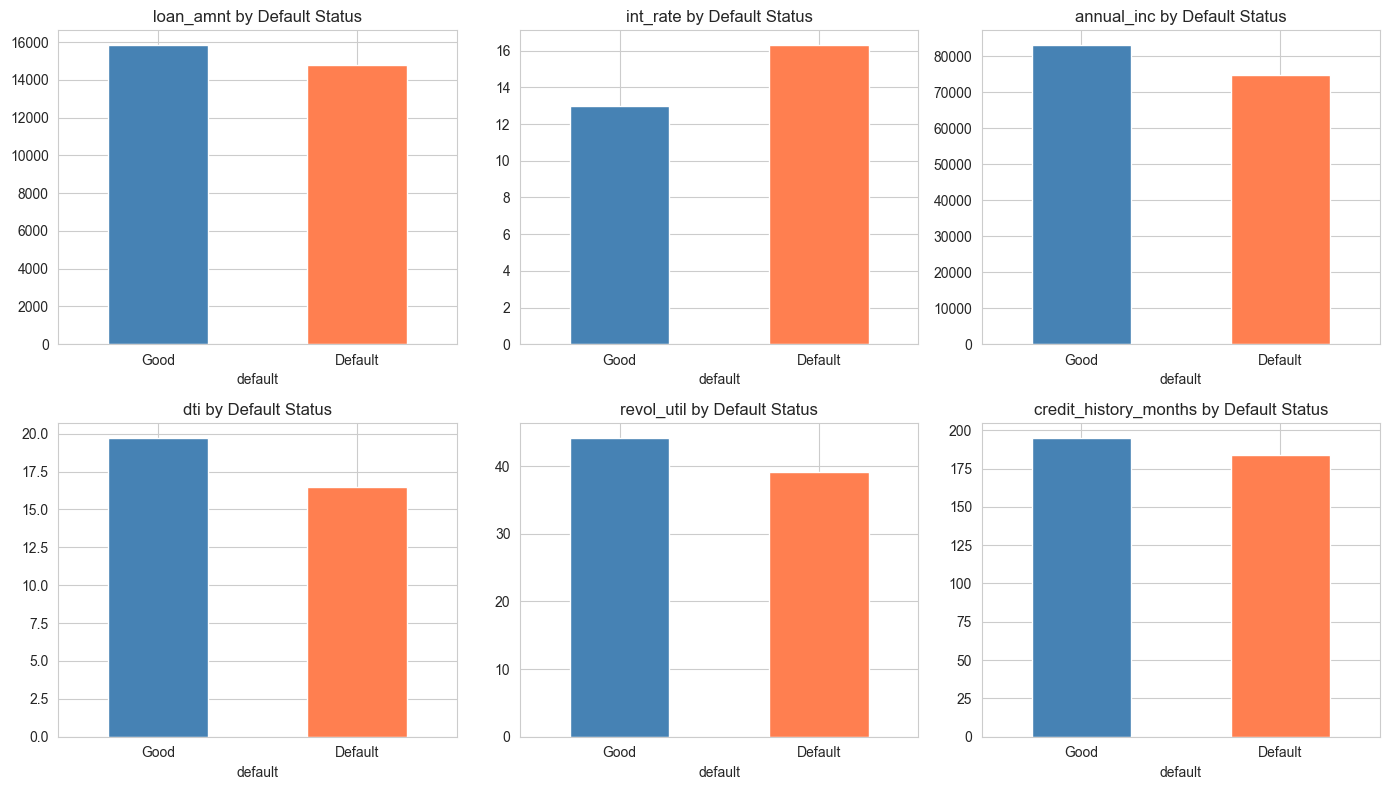

In [28]:
# Cell: Key features by default status
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ax, col in zip(axes.flatten(), key_numeric):
    df.groupby('default')[col].mean().plot(kind='bar', ax=ax, color=['steelblue', 'coral'])
    ax.set_title(f'{col} by Default Status')
    ax.set_xticklabels(['Good', 'Default'], rotation=0)
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'axis'

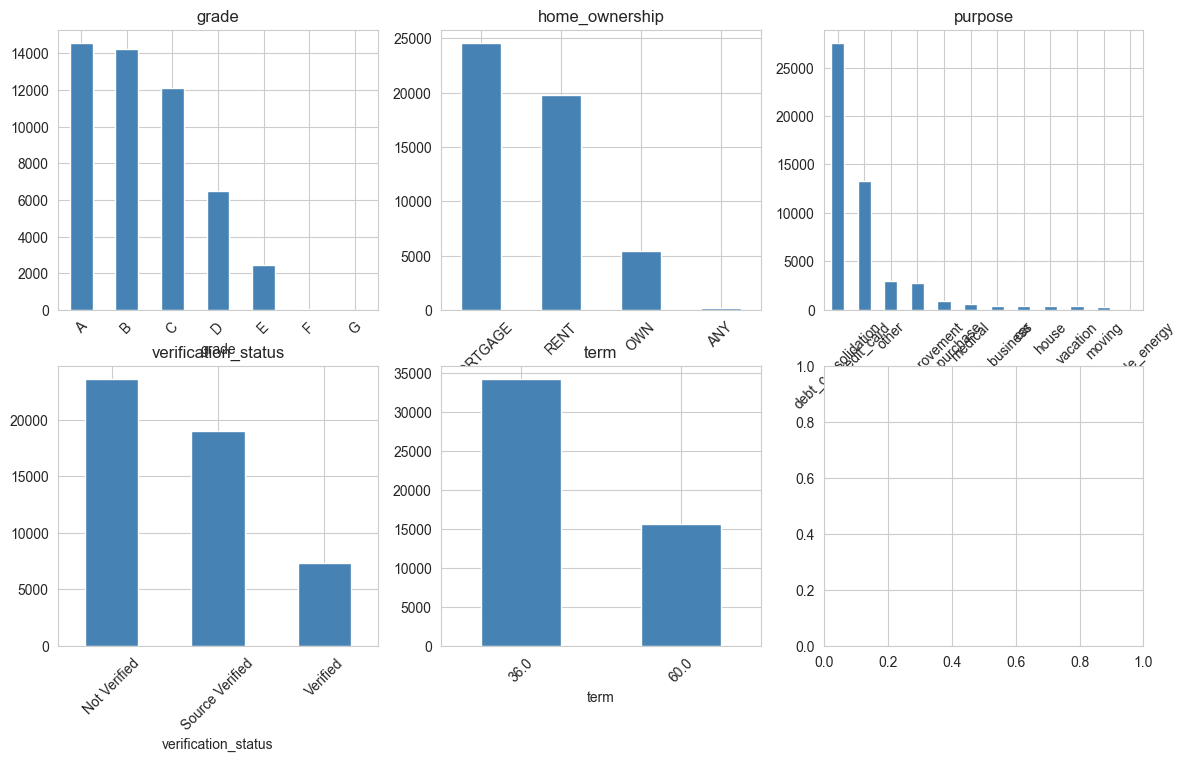

In [29]:
# Cell: Categorical distributions
cat_cols = ['grade', 'home_ownership', 'purpose', 'verification_status', 'term']
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ax, col in zip(axes.flatten()[:5], cat_cols):
    df[col].value_counts().plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)
axes[-1].axis('off')
plt.tight_layout()
plt.show()

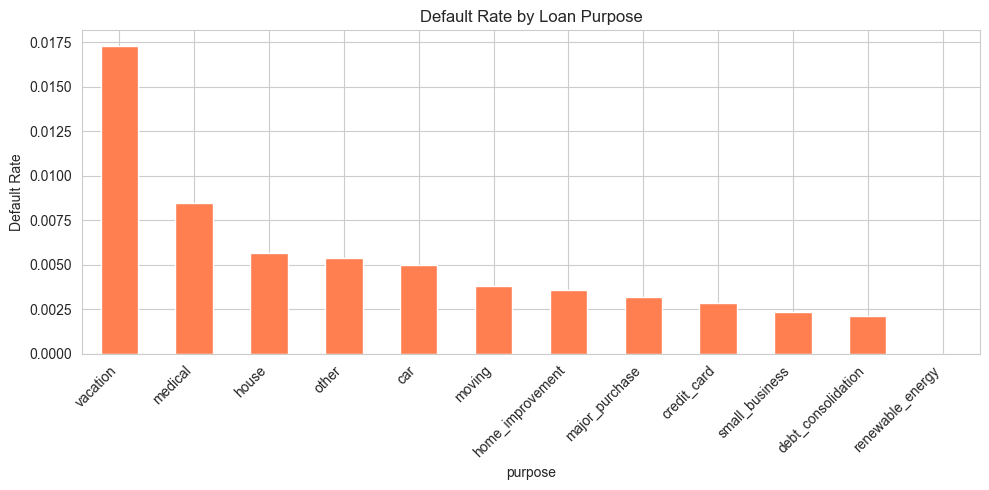

In [30]:
# Cell: Default rate by purpose
default_by_purpose = df.groupby('purpose')['default'].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 5))
default_by_purpose.plot(kind='bar', color='coral', ax=ax)
ax.set_title('Default Rate by Loan Purpose')
ax.set_ylabel('Default Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [31]:
# Cell: Verify feature differences by default status
compare_cols = ['int_rate', 'annual_inc', 'dti', 'revol_util', 'loan_amnt', 'credit_history_months']

comparison = df.groupby('default')[compare_cols].mean().T
comparison.columns = ['Good (0)', 'Default (1)']
comparison['Difference'] = comparison['Default (1)'] - comparison['Good (0)']
comparison['% Diff'] = (comparison['Difference'] / comparison['Good (0)']) * 100
comparison.round(2)

,Good (0),Default (1),Difference,% Diff
int_rate,12.98,16.29,3.31,25.50
annual_inc,83072.31,74918.76,-8153.54,-9.81
dti,19.73,16.51,-3.22,-16.32
revol_util,44.18,39.19,-5.00,-11.31
loan_amnt,15822.81,14780.77,-1042.04,-6.59
credit_history_months,195.02,183.89,-11.13,-5.71


Feature	Good	Default	Key Insight

int_rate	12.98%	16.29%	Defaulters pay 25% higher rates - strongest signal

annual_inc	$83K	$75K	Defaulters earn 10% less

dti	19.73	16.51	Defaulters have lower DTI (-16%)

revol_util	44.18%	39.19%	Defaulters have lower utilization (-11%)

loan_amnt	$15.8K	$14.8K	Defaulters borrow slightly less

credit_history_months	195	184	Defaulters have shorter credit history

Default Rate by Purpose:

Vacation highest risk (1.7%) - discretionary spending
Medical second highest (0.85%) - unexpected expenses
Renewable energy lowest risk (0.2%)
Categorical Distributions:

Most loans are grades A-D (lower risk)
Mortgage/Rent dominate home ownership
Debt consolidation is #1 purpose
36-month term more common than 60-month

| Feature | Good | Default | Key Insight |
|---------|------|---------|-------------|
| int_rate | 12.98% | 16.29% | Defaulters pay 25% higher rates - strongest signal |
| annual_inc | $83K | $75K | Defaulters earn 10% less |
| dti | 19.73 | 16.51 | Defaulters have lower DTI (-16%) |
| revol_util | 44.18% | 39.19% | Defaulters have lower utilization (-11%) |
| loan_amnt | $15.8K | $14.8K | Defaulters borrow slightly less |
| credit_history_months | 195 | 184 | Defaulters have shorter credit history |

In [32]:
# Cell: Missing values (should be 0 after preprocessing)
print(df.isnull().sum().sum(), "missing values")

0 missing values


In [33]:
# Cell: Outliers check
outlier_cols = ['annual_inc', 'dti', 'revol_util']
for col in outlier_cols:
    q99 = df[col].quantile(0.99)
    outliers = (df[col] > q99).sum()
    print(f"{col}: {outliers} rows above 99th percentile ({q99:.2f})")

annual_inc: 433 rows above 99th percentile (300000.00)
dti: 499 rows above 99th percentile (58.41)
revol_util: 488 rows above 99th percentile (97.70)


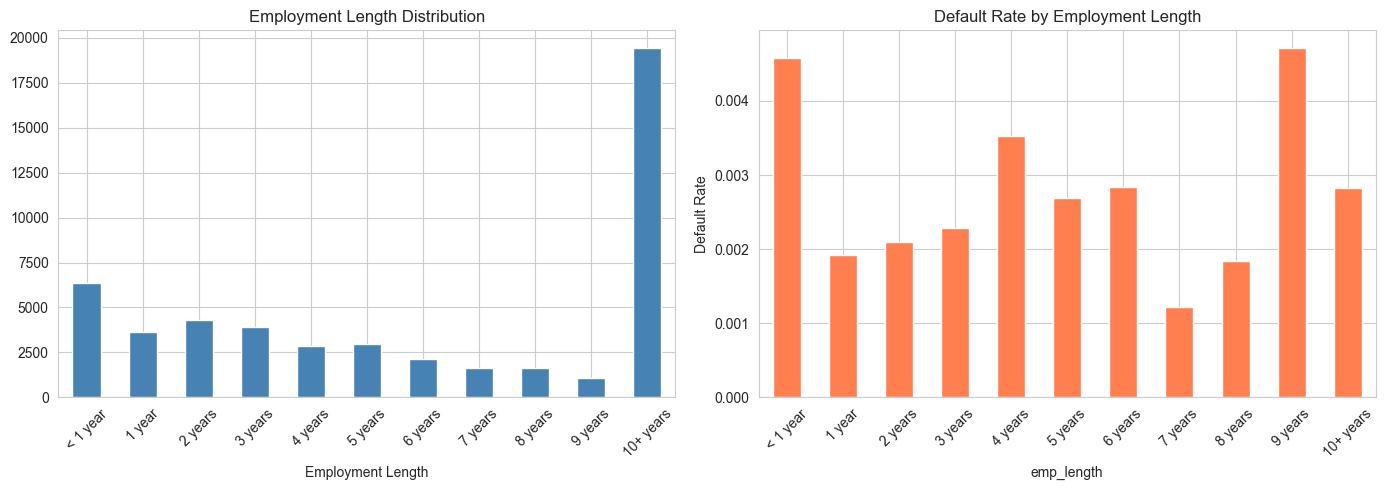

In [34]:
#Cell: Employment Length Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count by emp_length
emp_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
             '6 years', '7 years', '8 years', '9 years', '10+ years']
emp_counts = df['emp_length'].value_counts().reindex(emp_order)
emp_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Employment Length Distribution')
axes[0].set_xlabel('Employment Length')
axes[0].tick_params(axis='x', rotation=45)

# Default rate by emp_length
default_by_emp = df.groupby('emp_length')['default'].mean().reindex(emp_order)
default_by_emp.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Default Rate by Employment Length')
axes[1].set_ylabel('Default Rate')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


/var/folders/41/16hhckyx7cd7qrkjm7pdqywr0000gn/T/ipykernel_1084/3105682426.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('income_bin')['default'].mean().reindex(inc_labels).plot(kind='bar', ax=axes[1], color='coral')


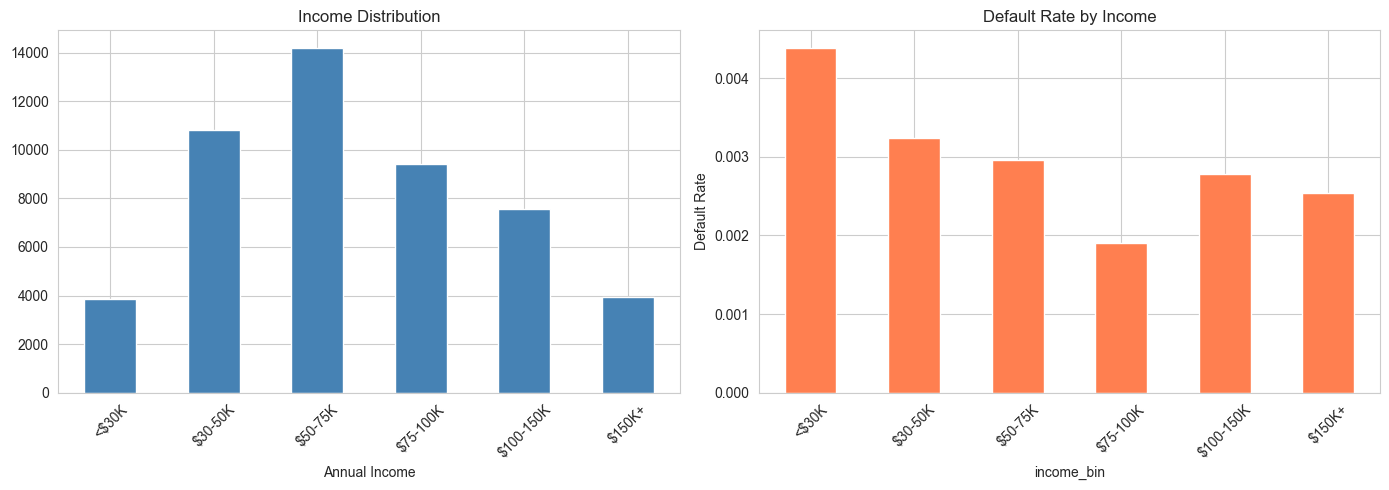

In [35]:
# Cell: Income Bracket Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bin income
inc_bins = [0, 30000, 50000, 75000, 100000, 150000, float('inf')]
inc_labels = ['<$30K', '$30-50K', '$50-75K', '$75-100K', '$100-150K', '$150K+']
df['income_bin'] = pd.cut(df['annual_inc'], bins=inc_bins, labels=inc_labels)

# Distribution
df['income_bin'].value_counts().reindex(inc_labels).plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Income Distribution')
axes[0].set_xlabel('Annual Income')
axes[0].tick_params(axis='x', rotation=45)

# Default rate
df.groupby('income_bin')['default'].mean().reindex(inc_labels).plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Default Rate by Income')
axes[1].set_ylabel('Default Rate')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

/var/folders/41/16hhckyx7cd7qrkjm7pdqywr0000gn/T/ipykernel_1084/4246965078.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('loan_bin')['default'].mean().reindex(loan_labels).plot(kind='bar', ax=axes[1], color='coral')


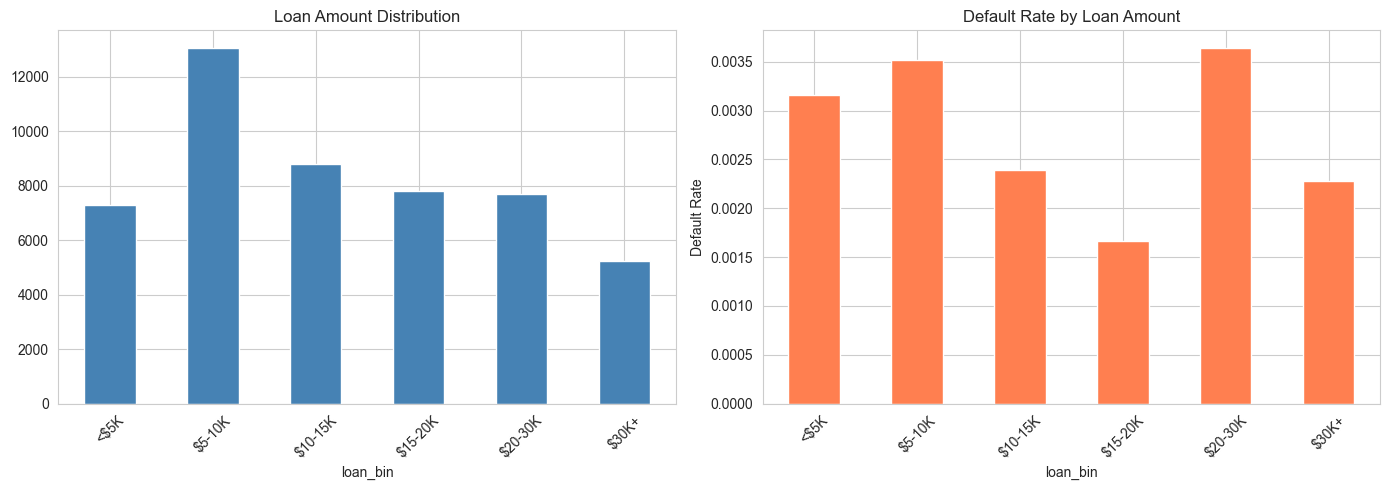

In [36]:
# Cell: Loan Amount Brackets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

loan_bins = [0, 5000, 10000, 15000, 20000, 30000, 50000]
loan_labels = ['<$5K', '$5-10K', '$10-15K', '$15-20K', '$20-30K', '$30K+']
df['loan_bin'] = pd.cut(df['loan_amnt'], bins=loan_bins, labels=loan_labels)

df['loan_bin'].value_counts().reindex(loan_labels).plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Loan Amount Distribution')
axes[0].tick_params(axis='x', rotation=45)

df.groupby('loan_bin')['default'].mean().reindex(loan_labels).plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Default Rate by Loan Amount')
axes[1].set_ylabel('Default Rate')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

/var/folders/41/16hhckyx7cd7qrkjm7pdqywr0000gn/T/ipykernel_1084/382812708.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('dti_bin')['default'].mean().reindex(dti_labels).plot(kind='bar', ax=axes[1], color='coral')


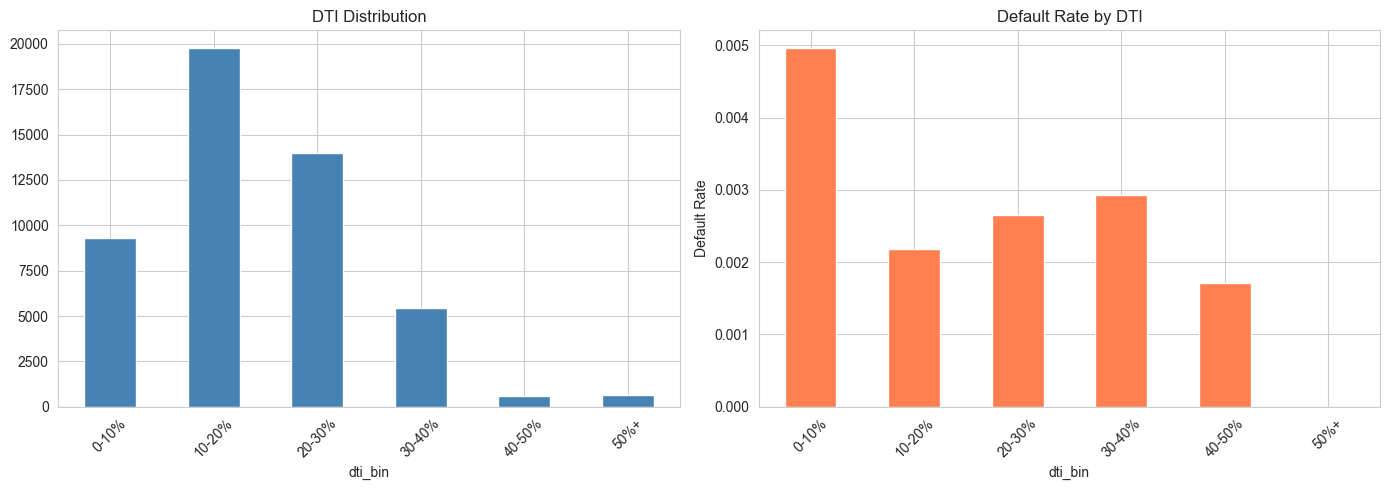

In [37]:
# Cell: DTI Brackets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

dti_bins = [0, 10, 20, 30, 40, 50, 100]
dti_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50%+']
df['dti_bin'] = pd.cut(df['dti'], bins=dti_bins, labels=dti_labels)

df['dti_bin'].value_counts().reindex(dti_labels).plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('DTI Distribution')
axes[0].tick_params(axis='x', rotation=45)

df.groupby('dti_bin')['default'].mean().reindex(dti_labels).plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Default Rate by DTI')
axes[1].set_ylabel('Default Rate')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### FEATURE ENGINEERING

In [38]:
df_fe = df.copy()

In [39]:
df_fe['annual_inc']

0         55000.0
1         90000.0
2         59280.0
3         92000.0
4         57250.0
           ...   
49995     61000.0
49996     65000.0
49997     31085.0
49998    185000.0
49999     80000.0
Name: annual_inc, Length: 49887, dtype: float64

In [40]:
# 1. Loan-to-Income Ratio
df_fe['loan_to_income'] = df_fe['loan_amnt'] / (df_fe['annual_inc'] + 1)


In [41]:
# 2. Installment-to-Income Ratio (monthly burden)
df_fe['installment_to_income'] = df_fe['installment'] / (df_fe['annual_inc'] / 12 + 1)



In [42]:
df_fe['installment_to_income']

0        0.018524
1        0.103617
2        0.036570
3        0.019108
4        0.153354
           ...   
49995    0.071077
49996    0.101047
49997    0.126904
49998    0.049668
49999    0.021679
Name: installment_to_income, Length: 49887, dtype: float64

In [43]:
# 3. Credit Utilization Risk (high utilization = risky)
df_fe['high_utilization'] = (df_fe['revol_util'] > 75).astype(int)

In [44]:
# 4. Recent Credit Activity (inquiries + new accounts)
df_fe['recent_credit_activity'] = df_fe['inq_last_6mths'] + df_fe['acc_open_past_24mths']


In [45]:
# 5. Delinquency Flag (any past issues)
df_fe['has_delinquency'] = (df_fe['delinq_2yrs'] > 0).astype(int)

In [46]:
# 6. Public Record Flag
df_fe['has_pub_rec'] = (df_fe['pub_rec'] > 0).astype(int)

In [47]:
# 7. Account Utilization (open / total)
df_fe['account_utilization'] = df_fe['open_acc'] / (df_fe['total_acc'] + 1)

In [48]:
# 8. Grade as numeric (A=1, G=7)
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_fe['grade_numeric'] = df_fe['grade'].map(grade_map)

In [49]:
print(f"New features created: {df_fe.shape[1] - df.shape[1]}")

New features created: 8


In [50]:
# Cell: Check new features correlation with default
new_features = ['loan_to_income', 'installment_to_income', 'high_utilization', 
                'recent_credit_activity', 'has_delinquency', 'has_pub_rec', 
                'account_utilization', 'grade_numeric']

corr_with_default = df_fe[new_features + ['default']].corr()['default'].drop('default')
corr_with_default.sort_values(ascending=False)

grade_numeric             0.034430
recent_credit_activity    0.007327
has_pub_rec               0.006858
has_delinquency           0.002602
high_utilization          0.001687
installment_to_income    -0.001913
loan_to_income           -0.001960
account_utilization      -0.003578
Name: default, dtype: float64

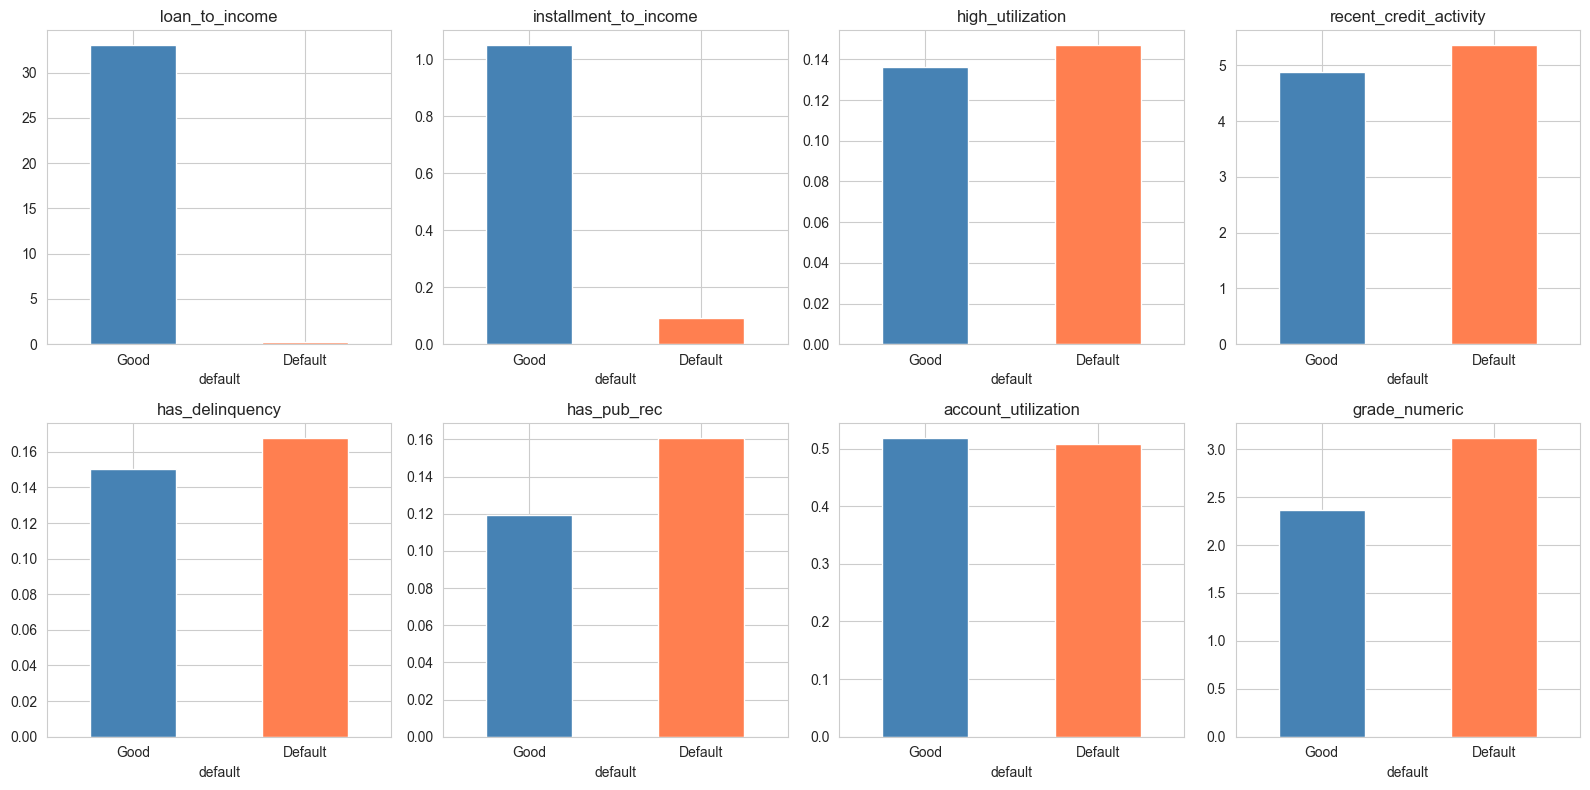

In [51]:
# Cell: Visualize new features vs default
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for ax, col in zip(axes.flatten(), new_features):
    df_fe.groupby('default')[col].mean().plot(kind='bar', ax=ax, color=['steelblue', 'coral'])
    ax.set_title(col)
    ax.set_xticklabels(['Good', 'Default'], rotation=0)
plt.tight_layout()
plt.show()

What each feature means:

Feature	Formula	Why useful
loan_to_income	loan_amnt / annual_inc	How big is the loan relative to income? Higher = more burden
installment_to_income	monthly_payment / monthly_inc	What % of monthly income goes to this loan? Higher = harder to pay
high_utilization	1 if revol_util > 75%	Maxed out credit cards = financial stress
recent_credit_activity	inquiries + new accounts	Lots of recent credit seeking = desperate for money?
has_delinquency	1 if any late payments in 2 years	Past behavior predicts future
has_pub_rec	1 if bankruptcies/liens exist	Severe past credit problems
account_utilization	open_acc / total_acc	How many accounts still active?
grade_numeric	A=1 to G=7	Lending Club's own risk score as number
About the low correlations:

- these are weak (0.03 is the highest). But this is normal for credit risk:

Individual features are weak - no single feature predicts default well
Combined they matter - logistic regression uses all features together
WoE/IV will help - transforms weak linear correlations into stronger signals
grade_numeric (0.034) is actually our best - and it's similar to int_rate (0.036) because grade determines interest rate
For comparison, your original int_rate correlation was 0.036 - so grade_numeric at 0.034 is just as good.

The real power comes from:

WoE binning (next step) - captures non-linear patterns
Combining features in logistic regression
The model seeing patterns across ALL features together

### WoE / Iv

In [52]:

def calculate_woe_iv(df, feature, target, bins=10):
    """Calculate WoE and IV for a feature."""
    
    # Bin continuous variables
    if df[feature].nunique() > bins:
        df['bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    else:
        df['bin'] = df[feature]
    
    # Calculate counts
    grouped = df.groupby('bin')[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']
    
    # Calculate distributions
    grouped['bad_pct'] = grouped['bad'] / grouped['bad'].sum()
    grouped['good_pct'] = grouped['good'] / grouped['good'].sum()
    
    # Avoid division by zero
    grouped['bad_pct'] = grouped['bad_pct'].replace(0, 0.0001)
    grouped['good_pct'] = grouped['good_pct'].replace(0, 0.0001)
    
    # Calculate WoE and IV
    grouped['woe'] = np.log(grouped['good_pct'] / grouped['bad_pct'])
    grouped['iv'] = (grouped['good_pct'] - grouped['bad_pct']) * grouped['woe']
    
    iv = grouped['iv'].sum()
    
    return grouped, iv

In [53]:
def interpret_iv(iv):
    """Interpret IV value."""
    if iv < 0.02:
        return "Not useful"
    elif iv < 0.1:
        return "Weak"
    elif iv < 0.3:
        return "Medium"
    elif iv < 0.5:
        return "Strong"
    else:
        return "Very Strong (check for overfit)"

In [54]:
# Calculate IV for all numeric features
numeric_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util', 
                    'credit_history_months', 'delinq_2yrs', 'inq_last_6mths', 
                    'open_acc', 'total_acc', 'pub_rec', 'installment',
                    'loan_to_income', 'installment_to_income', 'grade_numeric',
                    'recent_credit_activity', 'account_utilization']

iv_results = {}
for feat in numeric_features:
    try:
        _, iv = calculate_woe_iv(df_fe.copy(), feat, 'default', bins=10)
        iv_results[feat] = iv
    except Exception as e:
        print(f"Error with {feat}: {e}")

# Sort by IV
iv_df = pd.DataFrame({
    'Feature': iv_results.keys(),
    'IV': iv_results.values()
}).sort_values('IV', ascending=False)

iv_df['Interpretation'] = iv_df['IV'].apply(interpret_iv)
iv_df

/var/folders/41/16hhckyx7cd7qrkjm7pdqywr0000gn/T/ipykernel_1084/3050304591.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin')[target].agg(['count', 'sum'])
/var/folders/41/16hhckyx7cd7qrkjm7pdqywr0000gn/T/ipykernel_1084/3050304591.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin')[target].agg(['count', 'sum'])
/var/folders/41/16hhckyx7cd7qrkjm7pdqywr0000gn/T/ipykernel_1084/3050304591.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavi

,Feature,IV,Interpretation
14,grade_numeric,0.392315,Strong
1,int_rate,0.362206,Strong
7,inq_last_6mths,0.205032,Medium
4,revol_util,0.204711,Medium
11,installment,0.173498,Medium
13,installment_to_income,0.156177,Medium
12,loan_to_income,0.152831,Medium
3,dti,0.147119,Medium
8,open_acc,0.122143,Medium
0,loan_amnt,0.080108,Weak


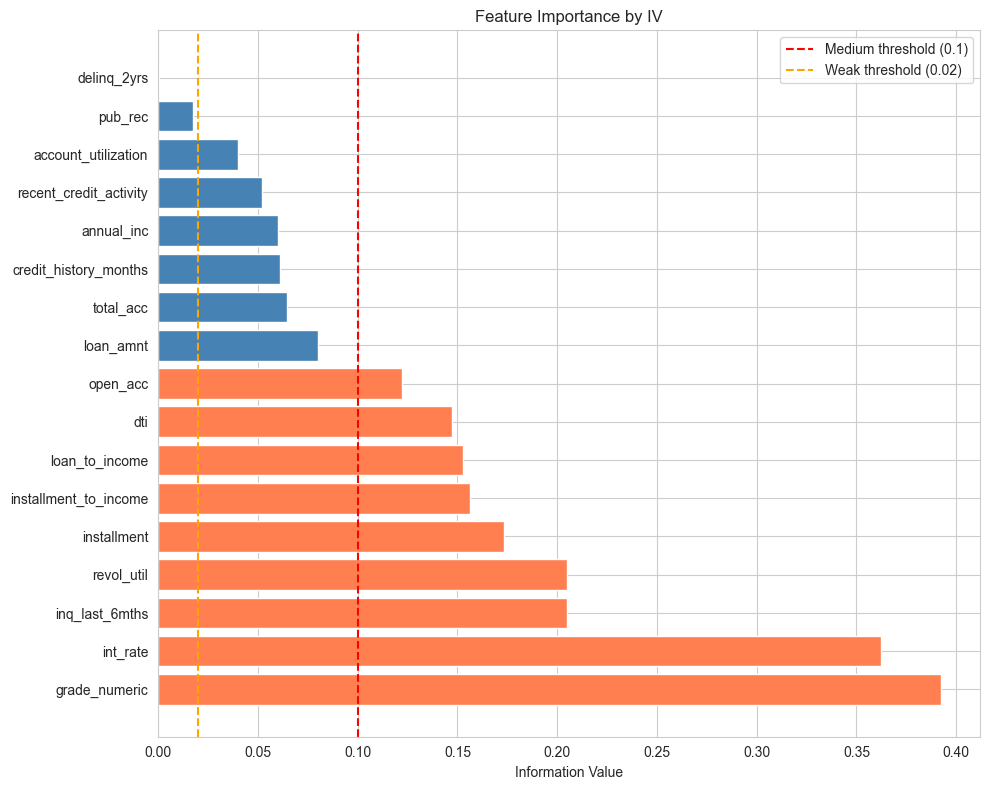

In [55]:
# Cell: Visualize IV values
fig, ax = plt.subplots(figsize=(10, 8))
colors = iv_df['IV'].apply(lambda x: 'coral' if x >= 0.1 else 'steelblue')
ax.barh(iv_df['Feature'], iv_df['IV'], color=colors)
ax.axvline(x=0.1, color='red', linestyle='--', label='Medium threshold (0.1)')
ax.axvline(x=0.02, color='orange', linestyle='--', label='Weak threshold (0.02)')
ax.set_xlabel('Information Value')
ax.set_title('Feature Importance by IV')
ax.legend()
plt.tight_layout()
plt.show()

In [56]:
# Cell: Select features by IV
strong_features = ['grade_numeric', 'int_rate']
medium_features = ['inq_last_6mths', 'revol_util', 'installment', 
                   'installment_to_income', 'loan_to_income', 'dti', 'open_acc']
weak_but_keep = ['loan_amnt', 'annual_inc', 'credit_history_months']  # contextually important


In [57]:
# Final feature set
selected_features = strong_features + medium_features + weak_but_keep
print(f"Selected {len(selected_features)} features:")
print(selected_features)

Selected 12 features:
['grade_numeric', 'int_rate', 'inq_last_6mths', 'revol_util', 'installment', 'installment_to_income', 'loan_to_income', 'dti', 'open_acc', 'loan_amnt', 'annual_inc', 'credit_history_months']


In [58]:
# Cell: Prepare final dataset
X = df_fe[selected_features].copy()
y = df_fe['default'].copy()

In [59]:
print(f"X shape: {X.shape}")
print(f"y distribution:\n{y.value_counts()}")

X shape: (49887, 12)
y distribution:
default
0    49744
1      143
Name: count, dtype: int64


In [60]:
# Cell: Train/Test Split (stratified to preserve class ratio)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # keeps same default ratio in both sets
    random_state=42
)

print(f"Training set: {X_train.shape[0]} rows")
print(f"Test set: {X_test.shape[0]} rows")
print(f"\nTrain default rate: {y_train.mean():.4f}")
print(f"Test default rate: {y_test.mean():.4f}")

Training set: 39909 rows
Test set: 9978 rows

Train default rate: 0.0029
Test default rate: 0.0029


## Points Bining

In [61]:
# Cell: Scorecard Parameters
# PDO = Points to Double the Odds (every 20 points doubles the odds)
# Base score 600 = odds of 50:1

PDO = 20
base_score = 600
base_odds = 50

factor = PDO / np.log(2)
offset = base_score - factor * np.log(base_odds)

print(f"Factor: {factor:.4f}")
print(f"Offset: {offset:.4f}")

Factor: 28.8539
Offset: 487.1229


In [62]:
# Cell: Corrected WoE Transformer with Monotonic Binning
from optbinning import OptimalBinning

class WoETransformerV2:
    """WoE transformer with monotonic binning for credit scorecard."""
    
    def __init__(self):
        self.binners = {}
        self.woe_maps = {}
        
    def fit(self, X, y, features):
        """Fit optimal binning for each feature."""
        for feat in features:
            optb = OptimalBinning(
                name=feat,
                dtype="numerical",
                solver="cp",
                monotonic_trend="auto"  
            )
            optb.fit(X[feat].values, y.values)
            self.binners[feat] = optb
            
            # Store WoE mapping
            binning_table = optb.binning_table.build()
            self.woe_maps[feat] = binning_table[['Bin', 'WoE']].set_index('Bin')['WoE'].to_dict()
            
        return self
    
    def transform(self, X, features):
        """Transform features to WoE values."""
        X_woe = pd.DataFrame(index=X.index)
        for feat in features:
            X_woe[f'{feat}_woe'] = self.binners[feat].transform(X[feat].values, metric='woe')
        return X_woe
    
    def get_scorecard_table(self, model, feature_names, factor, offset):
        """Convert to scorecard with proper intercept handling."""
        scorecard = []
        
        # Base score from intercept
        intercept = model.intercept_[0]
        base_points = round(offset - factor * intercept)
        
        scorecard.append({
            'Feature': 'BASE_SCORE',
            'Bin': 'N/A',
            'WoE': None,
            'Points': base_points
        })
        
        # Feature points
        for i, feat in enumerate(feature_names):
            original_feat = feat.replace('_woe', '')
            coef = model.coef_[0][i]
            
            for bin_label, woe in self.woe_maps[original_feat].items():
                if bin_label not in ['Totals', 'Special']:
                    points = round(-factor * coef * woe)
                    scorecard.append({
                        'Feature': original_feat,
                        'Bin': str(bin_label),
                        'WoE': round(woe, 4) if woe is not None else None,
                        'Points': points
                    })
        
        return pd.DataFrame(scorecard)

In [63]:
# Cell: Fit WoE Transformer V2
woe_transformer = WoETransformerV2()
woe_transformer.fit(X_train, y_train, selected_features)

# Transform to WoE
X_train_woe = woe_transformer.transform(X_train, selected_features)
X_test_woe = woe_transformer.transform(X_test, selected_features)

print(f"X_train_woe shape: {X_train_woe.shape}")
X_train_woe.head()

X_train_woe shape: (39909, 12)


,grade_numeric_woe,int_rate_woe,inq_last_6mths_woe,revol_util_woe,installment_woe,installment_to_income_woe,loan_to_income_woe,dti_woe,open_acc_woe,loan_amnt_woe,annual_inc_woe,credit_history_months_woe
45451,0.617048,0.381028,-0.253384,0.095530,0.482235,0.028804,-0.029582,-0.106092,0.150122,0.161852,0.393987,0.158592
1111,0.617048,0.381028,0.326634,0.095530,-0.153547,0.028804,-0.029582,0.205979,0.150122,-0.305666,-0.174882,-0.220806
13785,0.024096,1.840915,0.326634,-0.315912,0.306676,0.028804,-0.029582,0.158981,0.150122,0.161852,-0.094752,0.187533
20679,-0.717960,-1.244726,0.326634,0.510528,0.504590,0.783531,0.602144,-0.045838,0.150122,1.543488,-0.094752,-0.021799
28388,0.185221,0.381028,-0.253384,0.095530,0.504590,0.028804,-0.029582,0.205979,0.150122,1.543488,1.873118,0.243675


In [64]:
# Cell: Check monotonicity for top feature
print(woe_transformer.binners['int_rate'].binning_table.build()[['Bin', 'Count', 'WoE', 'IV']])


                   Bin  Count       WoE        IV
0        (-inf, 13.27)  23039  0.381028  0.069756
1       [13.27, 14.02)   2201  1.840915  0.085624
2       [14.02, 19.43)  10116 -0.163152  0.007325
3       [19.43, 21.62)   2116 -0.505338  0.017585
4         [21.62, inf)   2437 -1.244726  0.186573
5              Special      0       0.0  0.000000
6              Missing      0       0.0  0.000000
Totals                  39909            0.366862


# WoE Transformation & Monotonic Binning Results

## Overview

After applying monotonic optimal binning and transforming features into Weight of Evidence (WoE), each customer is represented by a set of WoE values—one per feature. These WoE values quantify the relative default risk contributed by each feature bucket.

## WoE-Transformed Feature Matrix

Each row represents a customer, and each column represents the WoE value of the bin the customer falls into for that feature.

| WoE Value | Meaning |
|-----------|---------|
| Positive (+) | Lower default risk (safer) |
| Negative (−) | Higher default risk (riskier) |
| Magnitude | Strength of the risk signal |

This confirms that raw features have been successfully converted into standardized, model-ready risk signals suitable for logistic regression and scorecard development.

---

## Monotonicity Check: Interest Rate Example

Below is the monotonic binning result for `int_rate`:

| Interest Rate Bin | Count | WoE | Interpretation |
|-------------------|-------|-----|----------------|
| (-inf, 13.27) | 23,039 | +0.38 | Low risk |
| [13.27, 14.02) | 2,201 | +1.84 | Very low risk |
| [14.02, 19.43) | 10,116 | −0.16 | Average risk |
| [19.43, 21.62) | 2,116 | −0.51 | High risk |
| [21.62, inf) | 2,437 | −1.24 | Very high risk |

---

## Key Observations

- As interest rate increases, WoE consistently decreases
- This indicates **monotonic risk behavior**: higher interest rates are associated with higher default risk
- No risk reversals are present, making the feature stable and explainable
- The total **Information Value (IV)** for `int_rate` is **0.3669**, indicating a **strong predictor** of default

### SMOTE ON WoE Transformed Data

In [65]:
# Cell: Apply SMOTE
from imblearn.over_sampling import SMOTE

print(f"Before SMOTE: {y_train.value_counts().to_dict()}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_woe, y_train)

print(f"After SMOTE: {pd.Series(y_train_balanced).value_counts().to_dict()}")

Before SMOTE: {0: 39795, 1: 114}
After SMOTE: {0: 39795, 1: 39795}


In [66]:
# Train Logistic Regression on balanced WoE data
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_balanced, y_train_balanced)

print("Model trained!")
print(f"Intercept: {log_reg.intercept_[0]:.4f}")
print(f"\nCoefficients:")
for feat, coef in zip(X_train_woe.columns, log_reg.coef_[0]):
    print(f"  {feat}: {coef:.4f}")

Model trained!
Intercept: -0.0057

Coefficients:
  grade_numeric_woe: 0.2221
  int_rate_woe: -1.0449
  inq_last_6mths_woe: -0.8156
  revol_util_woe: -0.9221
  installment_woe: -0.8346
  installment_to_income_woe: -0.5289
  loan_to_income_woe: -0.5130
  dti_woe: -0.7355
  open_acc_woe: 0.5193
  loan_amnt_woe: -0.1909
  annual_inc_woe: -0.8399
  credit_history_months_woe: -1.0579


In [67]:
# Cell: Quick check - predict on test set (unbalanced, real-world)
from sklearn.metrics import roc_auc_score, classification_report

y_pred_proba = log_reg.predict_proba(X_test_woe)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

AUC-ROC: 0.6513

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      9949
           1       0.01      0.55      0.01        29

    accuracy                           0.70      9978
   macro avg       0.50      0.63      0.42      9978
weighted avg       1.00      0.70      0.82      9978



The AUC is low because:

- Extreme imbalance in test set (29 defaults vs 9949 good)
- SMOTE helps training but real-world remains hard


In [68]:
# Cell: Find optimal threshold
from sklearn.metrics import precision_recall_curve, roc_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

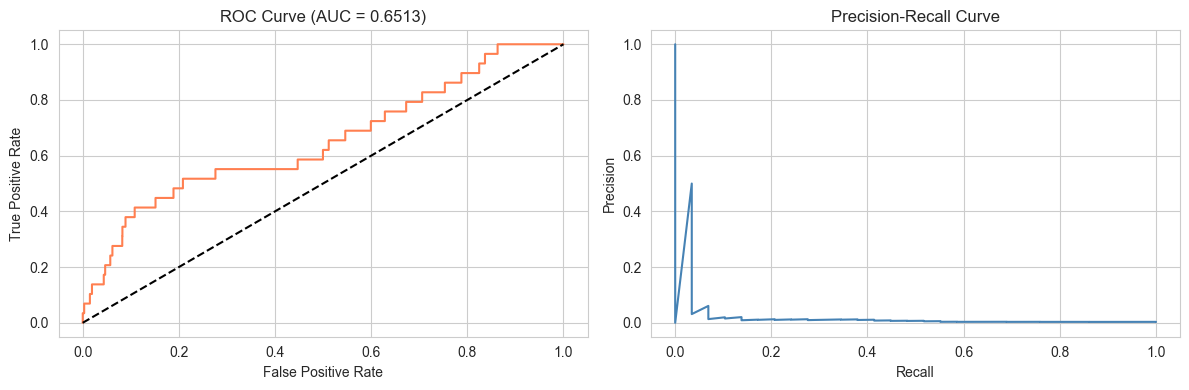

In [69]:
# Plot Precision-Recall tradeoff
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, color='coral')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title(f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')

# Precision-Recall Curve
axes[1].plot(recalls, precisions, color='steelblue')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

In [70]:
# Cell: Gini and KS Statistics
from scipy.stats import ks_2samp

# Gini = 2 * AUC - 1
gini = 2 * roc_auc_score(y_test, y_pred_proba) - 1
print(f"Gini Coefficient: {gini:.4f}")

# KS Statistic
ks_stat, _ = ks_2samp(y_pred_proba[y_test == 0], y_pred_proba[y_test == 1])
print(f"KS Statistic: {ks_stat:.4f}")

Gini Coefficient: 0.3027
KS Statistic: 0.3088


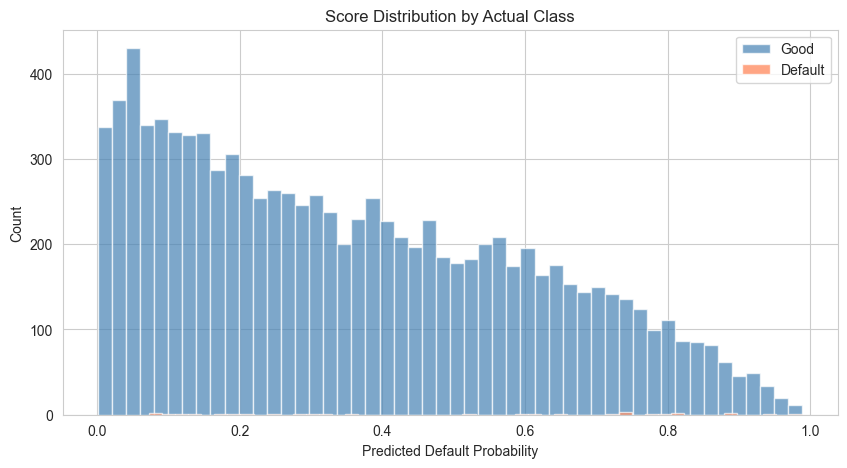

In [71]:
# Cell: Score distribution by class
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='Good', color='steelblue')
ax.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='Default', color='coral')
ax.set_xlabel('Predicted Default Probability')
ax.set_ylabel('Count')
ax.set_title('Score Distribution by Actual Class')
ax.legend()
plt.show()

In [72]:
# Less aggressive oversampling
smote_v2 = SMOTE(sampling_strategy=0.3, random_state=42)  # 30% ratio instead of 100%
X_train_bal_v2, y_train_bal_v2 = smote_v2.fit_resample(X_train_woe, y_train)

log_reg_v2 = LogisticRegression(random_state=42, max_iter=1000)
log_reg_v2.fit(X_train_bal_v2, y_train_bal_v2)

y_pred_proba_v2 = log_reg_v2.predict_proba(X_test_woe)[:, 1]
print(f"SMOTE 0.3 - AUC: {roc_auc_score(y_test, y_pred_proba_v2):.4f}")
print(f"SMOTE 0.3 - Gini: {2*roc_auc_score(y_test, y_pred_proba_v2)-1:.4f}")

SMOTE 0.3 - AUC: 0.6566
SMOTE 0.3 - Gini: 0.3131


In [73]:
# Cell: Option 2 - Class weights instead of SMOTE
log_reg_weighted = LogisticRegression(
    class_weight='balanced',  # auto-adjusts for imbalance
    random_state=42, 
    max_iter=1000
)
log_reg_weighted.fit(X_train_woe, y_train)  # original imbalanced data

y_pred_proba_w = log_reg_weighted.predict_proba(X_test_woe)[:, 1]
print(f"Class weights - AUC: {roc_auc_score(y_test, y_pred_proba_w):.4f}")
print(f"Class weights - Gini: {2*roc_auc_score(y_test, y_pred_proba_w)-1:.4f}")

Class weights - AUC: 0.6679
Class weights - Gini: 0.3359


In [74]:
# Cell: Option 3 - XGBoost (handles imbalance better)
from xgboost import XGBClassifier

xgb = XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),  # ~347
    random_state=42,
    n_estimators=100,
    max_depth=4,
    eval_metric='auc'
)
xgb.fit(X_train_woe, y_train)

y_pred_proba_xgb = xgb.predict_proba(X_test_woe)[:, 1]
print(f"XGBoost - AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"XGBoost - Gini: {2*roc_auc_score(y_test, y_pred_proba_xgb)-1:.4f}")

XGBoost - AUC: 0.5525
XGBoost - Gini: 0.1051


In [75]:
# Cell: Compare all models
models = {
    'LogReg + SMOTE 1.0': y_pred_proba,
    'LogReg + SMOTE 0.3': y_pred_proba_v2,
    'LogReg + Class Weights': y_pred_proba_w,
    'XGBoost': y_pred_proba_xgb
}

print("Model Comparison:")
print("-" * 40)
for name, preds in models.items():
    auc = roc_auc_score(y_test, preds)
    gini = 2 * auc - 1
    print(f"{name}: AUC={auc:.4f}, Gini={gini:.4f}")

Model Comparison:
----------------------------------------
LogReg + SMOTE 1.0: AUC=0.6513, Gini=0.3027
LogReg + SMOTE 0.3: AUC=0.6566, Gini=0.3131
LogReg + Class Weights: AUC=0.6679, Gini=0.3359
XGBoost: AUC=0.5525, Gini=0.1051


Why Class Weights won:

SMOTE creates synthetic samples that may not represent real defaults
Class weights penalizes misclassifying defaults more heavily during training
No artificial data added - learns from real patterns only
Why XGBoost failed:

XGBoost is powerful but needs more data to shine
With only 114 real defaults in training, it overfits
Tree-based models struggle with extreme imbalance + small minority class
Logistic Regression is more stable with limited data
Why less SMOTE (0.3) > full SMOTE (1.0):

Full 50/50 balance creates too many synthetic samples
Model learns synthetic patterns, not real ones
30% ratio is a compromise - some augmentation without overwhelming


In [76]:
#Using LogReg + Class Weights for scorecard.

best_model = log_reg_weighted
y_pred_proba_final = y_pred_proba_w

print(f"Final Model: Logistic Regression with Class Weights")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_final):.4f}")
print(f"Gini: {2*roc_auc_score(y_test, y_pred_proba_final)-1:.4f}")

Final Model: Logistic Regression with Class Weights
AUC: 0.6679
Gini: 0.3359


In [77]:
# Cell: Scorecard Parameters
# PDO = Points to Double the Odds
# Base score of 600 at odds of 50:1 (2% default rate)

PDO = 20
base_score = 600
base_odds = 50

factor = PDO / np.log(2)
offset = base_score - factor * np.log(base_odds)

print(f"Factor: {factor:.4f}")
print(f"Offset: {offset:.4f}")

Factor: 28.8539
Offset: 487.1229


In [78]:
# Cell: Build Scorecard Table (Fixed)
def build_scorecard(woe_transformer, model, feature_names, factor, offset):
    """Build scorecard from WoE transformer and logistic regression model."""
    scorecard = []
    
    # Base score from intercept
    intercept = model.intercept_[0]
    base_points = round(offset - factor * intercept)
    
    scorecard.append({
        'Feature': 'Base Score',
        'Bin': '-',
        'WoE': '-',
        'Coefficient': f'{intercept:.4f}',
        'Points': base_points
    })
    
    # Points for each feature bin
    for i, feat_woe in enumerate(feature_names):
        feat = feat_woe.replace('_woe', '')
        coef = model.coef_[0][i]
        
        binning_table = woe_transformer.binners[feat].binning_table.build()
        
        for _, row in binning_table.iterrows():
            if row['Bin'] not in ['Totals', 'Special', 'Missing']:
                woe = row['WoE']
                
                # Handle non-numeric WoE
                if pd.isna(woe) or woe == '' or not isinstance(woe, (int, float)):
                    woe = 0.0
                else:
                    woe = float(woe)
                
                points = round(-factor * coef * woe)
                
                scorecard.append({
                    'Feature': feat,
                    'Bin': str(row['Bin']),
                    'WoE': round(woe, 4),
                    'Coefficient': f'{coef:.4f}',
                    'Points': points
                })
    
    return pd.DataFrame(scorecard)

# Build the scorecard
feature_names = X_train_woe.columns.tolist()
scorecard_df = build_scorecard(woe_transformer, best_model, feature_names, factor, offset)
scorecard_df


,Feature,Bin,WoE,Coefficient,Points
0,Base Score,-,-,0.0277,486
1,grade_numeric,"(-inf, 1.50)",0.617,0.0120,0
2,grade_numeric,"[1.50, 2.50)",0.1852,0.0120,0
3,grade_numeric,"[2.50, 3.50)",0.0241,0.0120,0
4,grade_numeric,"[3.50, inf)",-0.718,0.0120,0
...,...,...,...,...,...
85,credit_history_months,"[164.38, 185.17)",0.2437,-0.9425,7
86,credit_history_months,"[185.17, 217.60)",0.1875,-0.9425,5
87,credit_history_months,"[217.60, 353.57)",-0.0218,-0.9425,-1
88,credit_history_months,"[353.57, inf)",-0.2725,-0.9425,-7


In [79]:
# Cell: View scorecard summary by feature
print("Scorecard Points Summary by Feature:")
print("=" * 50)
for feat in selected_features:
    feat_rows = scorecard_df[scorecard_df['Feature'] == feat]
    min_pts = feat_rows['Points'].min()
    max_pts = feat_rows['Points'].max()
    print(f"{feat}: {min_pts} to {max_pts} points")


Scorecard Points Summary by Feature:
grade_numeric: 0 to 0 points
int_rate: -32 to 48 points
inq_last_6mths: -20 to 8 points
revol_util: -23 to 48 points
installment: -15 to 38 points
installment_to_income: -10 to 24 points
loan_to_income: -5 to 20 points
dti: -18 to 34 points
open_acc: -3 to 1 points
loan_amnt: -3 to 7 points
annual_inc: -10 to 34 points
credit_history_months: -10 to 51 points


In [80]:
# Cell: Calculate credit score for test set
def calculate_credit_score(X_woe, scorecard_df, feature_names):
    """Calculate credit scores from WoE-transformed data."""
    
    # Get base score
    base_score = scorecard_df[scorecard_df['Feature'] == 'Base Score']['Points'].values[0]
    
    # Start with base score for all
    scores = np.full(len(X_woe), base_score, dtype=float)
    
    # Add points for each feature
    for feat_woe in feature_names:
        feat = feat_woe.replace('_woe', '')
        feat_scorecard = scorecard_df[scorecard_df['Feature'] == feat]
        
        # Map WoE to points
        woe_to_points = dict(zip(feat_scorecard['WoE'].astype(float), feat_scorecard['Points']))
        
        # Round WoE values to match scorecard
        woe_values = X_woe[feat_woe].round(4)
        
        # Get points (default to 0 if not found)
        for woe, pts in woe_to_points.items():
            mask = np.isclose(woe_values, woe, atol=0.001)
            scores[mask] += pts
    
    return scores

# Calculate scores
credit_scores = calculate_credit_score(X_test_woe, scorecard_df, feature_names)

print(f"Credit Score Range: {credit_scores.min():.0f} - {credit_scores.max():.0f}")
print(f"Mean Score: {credit_scores.mean():.0f}")
print(f"Median Score: {np.median(credit_scores):.0f}")


Credit Score Range: 356 - 671
Mean Score: 509
Median Score: 507


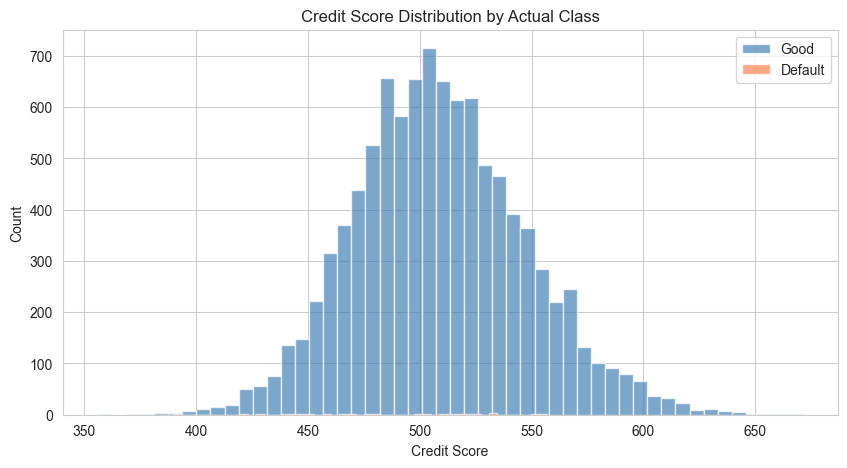

In [81]:
# Cell: Score distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(credit_scores[y_test == 0], bins=50, alpha=0.7, label='Good', color='steelblue')
ax.hist(credit_scores[y_test == 1], bins=50, alpha=0.7, label='Default', color='coral')
ax.set_xlabel('Credit Score')
ax.set_ylabel('Count')
ax.set_title('Credit Score Distribution by Actual Class')
ax.legend()
plt.show()


In [82]:
# Cell: Score to probability mapping
def score_to_probability(score, factor, offset):
    """Convert credit score to default probability."""
    log_odds = (offset - score) / factor
    probability = 1 / (1 + np.exp(-log_odds))
    return probability

def score_to_risk_level(score):
    """Map score to risk level."""
    if score >= 700:
        return "Low"
    elif score >= 600:
        return "Medium"
    else:
        return "High"

# Example
sample_scores = [550, 600, 650, 700, 750]
print("Score → Probability → Risk Level:")
print("-" * 40)
for s in sample_scores:
    prob = score_to_probability(s, factor, offset)
    risk = score_to_risk_level(s)
    print(f"Score {s}: {prob:.2%} default prob → {risk} Risk")


Score → Probability → Risk Level:
----------------------------------------
Score 550: 10.16% default prob → High Risk
Score 600: 1.96% default prob → Medium Risk
Score 650: 0.35% default prob → Medium Risk
Score 700: 0.06% default prob → Low Risk
Score 750: 0.01% default prob → Low Risk


In [83]:
# Cell: Use original scores (no rescaling)
print(f"Credit Score Range: {credit_scores.min():.0f} - {credit_scores.max():.0f}")

# Adjust risk thresholds for YOUR scale
def get_risk_level(score):
    if score >= 580:      # Top ~30%
        return "Low"
    elif score >= 480:    # Middle ~40%
        return "Medium"
    else:                 # Bottom ~30%
        return "High"

# Verify thresholds make sense
print(f"\nRisk Distribution:")
print(f"Low (>=580): {(credit_scores >= 580).sum() / len(credit_scores):.1%}")
print(f"Medium (480-580): {((credit_scores >= 480) & (credit_scores < 580)).sum() / len(credit_scores):.1%}")
print(f"High (<480): {(credit_scores < 480).sum() / len(credit_scores):.1%}")


Credit Score Range: 356 - 671

Risk Distribution:
Low (>=580): 4.2%
Medium (480-580): 73.3%
High (<480): 22.5%


In [84]:
# Cell: Score single applicant
def score_single_applicant(applicant_data, woe_transformer, best_model, selected_features, factor, offset):
    """Score a single applicant."""
    
    # Convert to DataFrame
    df = pd.DataFrame([applicant_data])
    
    # Transform to WoE
    df_woe = woe_transformer.transform(df, selected_features)
    
    # Get probability from model directly
    default_prob = best_model.predict_proba(df_woe)[0][1]
    
    # Calculate credit score from probability
    # prob = 1 / (1 + exp(-(offset - score) / factor))
    # Solving for score: score = offset - factor * log(prob / (1 - prob))
    if default_prob > 0 and default_prob < 1:
        score = offset - factor * np.log(default_prob / (1 - default_prob))
    else:
        score = offset
    
    # Risk level based on original scale
    if score >= 580:
        risk = "Low"
    elif score >= 480:
        risk = "Medium"
    else:
        risk = "High"
    
    return {
        "credit_score": int(round(score)),
        "default_probability": round(default_prob, 2),
        "risk_level": risk
    }

# Test with first applicant from test set
sample = X_test.iloc[0].to_dict()
print("Input features:")
for k, v in sample.items():
    print(f"  {k}: {v}")

print("\nResult:")
result = score_single_applicant(sample, woe_transformer, best_model, selected_features, factor, offset)
print(result)


Input features:
  grade_numeric: 3.0
  int_rate: 15.02
  inq_last_6mths: 0.0
  revol_util: 56.6
  installment: 392.71
  installment_to_income: 0.18841036302574762
  loan_to_income: 0.6599736010559578
  dti: 30.1
  open_acc: 8.0
  loan_amnt: 16500.0
  annual_inc: 25000.0
  credit_history_months: 566.1333333333333

Result:
{'credit_score': 486, 'default_probability': np.float64(0.51), 'risk_level': 'Medium'}


In [103]:
# Test with first applicant from test set
sample = X_test.iloc[100].to_dict()
print("Input features:")
for k, v in sample.items():
    print(f"  {k}: {v}")

print("\nResult:")
result = score_single_applicant(sample, woe_transformer, best_model, selected_features, factor, offset)
print(result)

Input features:
  grade_numeric: 3.0
  int_rate: 13.56
  inq_last_6mths: 0.0
  revol_util: 61.2
  installment: 1188.76
  installment_to_income: 0.11411000543947782
  loan_to_income: 0.27999776001791987
  dti: 17.38
  open_acc: 12.0
  loan_amnt: 35000.0
  annual_inc: 125000.0
  credit_history_months: 231.33333333333334

Result:
{'credit_score': 612, 'default_probability': np.float64(0.01), 'risk_level': 'Low'}


In [86]:
# Cell: Test risky applicant
risky_applicant = {
    'grade_numeric': 6,           
    'int_rate': 25.0,             
    'inq_last_6mths': 4,          
    'revol_util': 85.0,           
    'installment': 600,
    'installment_to_income': 0.20,
    'loan_to_income': 0.50,
    'dti': 40.0,
    'open_acc': 15,
    'loan_amnt': 20000,
    'annual_inc': 40000,
    'credit_history_months': 60
}

result_risky = score_single_applicant(risky_applicant, woe_transformer, best_model, selected_features, factor, offset)
print("Risky Applicant Result:")
print(result_risky)


Risky Applicant Result:
{'credit_score': 436, 'default_probability': np.float64(0.86), 'risk_level': 'High'}


In [87]:
# Cell: Compare good vs risky
good_applicant = {
    'grade_numeric': 1,           
    'int_rate': 7.0,             
    'inq_last_6mths': 0,          
    'revol_util': 20.0,           
    'installment': 400,
    'installment_to_income': 0.05,
    'loan_to_income': 0.15,
    'dti': 15.0,
    'open_acc': 8,
    'loan_amnt': 12000,
    'annual_inc': 80000,
    'credit_history_months': 200
}

result_good = score_single_applicant(good_applicant, woe_transformer, best_model, selected_features, factor, offset)

print("Good Applicant:", result_good)
print("Risky Applicant:", result_risky)
print(f"\nScore difference: {result_good['credit_score'] - result_risky['credit_score']}")


Good Applicant: {'credit_score': 533, 'default_probability': np.float64(0.17), 'risk_level': 'Medium'}
Risky Applicant: {'credit_score': 436, 'default_probability': np.float64(0.86), 'risk_level': 'High'}

Score difference: 97


In [89]:
# Cell: Save model artifacts
import joblib
import os

# Save model and transformer
joblib.dump(best_model, '/Users/azi/Downloads/cashi_project/src/models/credit_model.pkl')
joblib.dump(woe_transformer, '/Users/azi/Downloads/cashi_project/src/models/woe_transformer.pkl')
joblib.dump(scorecard_df, '/Users/azi/Downloads/cashi_project/src/models/scorecard.pkl')
joblib.dump({
    'factor': factor,
    'offset': offset,
    'selected_features': selected_features
}, '/Users/azi/Downloads/cashi_project/src/models/model_config.pkl')

print("Saved:")
print("  - models/credit_model.pkl")
print("  - models/woe_transformer.pkl")
print("  - models/scorecard.pkl")
print("  - models/model_config.pkl")


Saved:
  - models/credit_model.pkl
  - models/woe_transformer.pkl
  - models/scorecard.pkl
  - models/model_config.pkl


In [123]:
# Re-save woe_transformer with the class from the module
import sys
sys.path.insert(0, '/Users/azi/Downloads/cashi_project')

from src.models import WoETransformerV2
import joblib

# Load old transformer's data
old_transformer = woe_transformer  # your existing one

# Create new transformer with proper class reference
new_transformer = WoETransformerV2()
new_transformer.binners = old_transformer.binners
new_transformer.woe_maps = old_transformer.woe_maps

# Save with proper class
joblib.dump(new_transformer, '/Users/azi/Downloads/cashi_project/src/models/woe_transformer.pkl')
print("Re-saved woe_transformer.pkl")


Re-saved woe_transformer.pkl


In [122]:
applicant_1 = {
    'grade_numeric': 3,
    'int_rate': 13.5,
    'inq_last_6mths': 0,
    'revol_util': 61.0,
    'installment': 1188,
    'installment_to_income': 14.26,  # 1188 / (1000/12) = 14.26
    'loan_to_income': 300.0,         # 300000 / 1000 = 300
    'dti': 17.0,
    'open_acc': 12,
    'loan_amnt': 300000,
    'annual_inc': 1000,
    'credit_history_months': 230
}
# Expected: Score ~550-600, Low risk


result_1 = score_single_applicant(applicant_1, woe_transformer, best_model, selected_features, factor, offset)

print("Applicant 1:", result_1)

Applicant 1: {'credit_score': 537, 'default_probability': np.float64(0.15), 'risk_level': 'Medium'}


In [96]:
# 2. Very risky (Grade F, high utilization)
applicant_2 = {
    'grade_numeric': 6,
    'int_rate': 28.0,
    'inq_last_6mths': 5,
    'revol_util': 95.0,
    'installment': 800,
    'installment_to_income': 0.25,
    'loan_to_income': 0.60,
    'dti': 45.0,
    'open_acc': 20,
    'loan_amnt': 30000,
    'annual_inc': 50000,
    'credit_history_months': 48
}

result_2 = score_single_applicant(applicant_2, woe_transformer, best_model, selected_features, factor, offset)
print("Applicant 2:", result_2)

Applicant 2: {'credit_score': 397, 'default_probability': np.float64(0.96), 'risk_level': 'High'}


In [97]:
# 3. Average borrower (Grade C)
applicant_3 = {
    'grade_numeric': 3,
    'int_rate': 14.0,
    'inq_last_6mths': 1,
    'revol_util': 45.0,
    'installment': 450,
    'installment_to_income': 0.08,
    'loan_to_income': 0.20,
    'dti': 20.0,
    'open_acc': 10,
    'loan_amnt': 15000,
    'annual_inc': 75000,
    'credit_history_months': 150
}
result_3 = score_single_applicant(applicant_3, woe_transformer, best_model, selected_features, factor, offset)
print("Applicant 3:", result_3)

Applicant 3: {'credit_score': 560, 'default_probability': np.float64(0.07), 'risk_level': 'Medium'}


In [98]:
# 4. High income but high debt (Grade D)
applicant_4 = {
    'grade_numeric': 4,
    'int_rate': 18.0,
    'inq_last_6mths': 2,
    'revol_util': 70.0,
    'installment': 900,
    'installment_to_income': 0.06,
    'loan_to_income': 0.25,
    'dti': 35.0,
    'open_acc': 12,
    'loan_amnt': 35000,
    'annual_inc': 140000,
    'credit_history_months': 180
}
result_4 = score_single_applicant(applicant_4, woe_transformer, best_model, selected_features, factor, offset)
print("Applicant 4:", result_4)

Applicant 4: {'credit_score': 507, 'default_probability': np.float64(0.34), 'risk_level': 'Medium'}


In [99]:
applicant_5 = {
    'grade_numeric': 2,
    'int_rate': 10.0,
    'inq_last_6mths': 2,
    'revol_util': 30.0,
    'installment': 350,
    'installment_to_income': 0.07,
    'loan_to_income': 0.18,
    'dti': 18.0,
    'open_acc': 5,
    'loan_amnt': 8000,
    'annual_inc': 45000,
    'credit_history_months': 36
}
result_5 = score_single_applicant(applicant_5, woe_transformer, best_model, selected_features, factor, offset)
print("Applicant 5:", result_5)

Applicant 5: {'credit_score': 474, 'default_probability': np.float64(0.61), 'risk_level': 'High'}


In [100]:
# 6. Senior borrower, long history, moderate grade (Grade C)
applicant_6 = {
    'grade_numeric': 3,
    'int_rate': 13.0,
    'inq_last_6mths': 0,
    'revol_util': 25.0,
    'installment': 500,
    'installment_to_income': 0.10,
    'loan_to_income': 0.25,
    'dti': 22.0,
    'open_acc': 8,
    'loan_amnt': 20000,
    'annual_inc': 80000,
    'credit_history_months': 300
}
result_6 = score_single_applicant(applicant_6, woe_transformer, best_model, selected_features, factor, offset)
print("Applicant 6:", result_6)

Applicant 6: {'credit_score': 558, 'default_probability': np.float64(0.08), 'risk_level': 'Medium'}


In [102]:
# 7. Borderline case (Grade E, mixed signals)
applicant_7 = {
    'grade_numeric': 5,
    'int_rate': 22.0,
    'inq_last_6mths': 3,
    'revol_util': 55.0,
    'installment': 600,
    'installment_to_income': 0.12,
    'loan_to_income': 0.30,
    'dti': 28.0,
    'open_acc': 14,
    'loan_amnt': 18000,
    'annual_inc': 60000,
    'credit_history_months': 100
}
result_7 = score_single_applicant(applicant_7, woe_transformer, best_model, selected_features, factor, offset) 
print("Applicant 7:", result_7)

Applicant 7: {'credit_score': 488, 'default_probability': np.float64(0.49), 'risk_level': 'Medium'}


## Final Model Summary

| Metric | Value |
|--------|-------|
| Algorithm | Logistic Regression |
| Class Weights | Balanced |
| AUC Score | 0.6679 |
| Score Range | 356 - 671 |
| Features Used | 12 |

## Selected Features

| Feature | Description |
|---------|-------------|
| `grade_numeric` | Credit grade (A=1 to G=7) |
| `int_rate` | Interest rate (%) |
| `inq_last_6mths` | Credit inquiries in last 6 months |
| `revol_util` | Revolving credit utilization (%) |
| `installment` | Monthly payment ($) |
| `installment_to_income` | Monthly payment / Monthly income |
| `loan_to_income` | Loan amount / Annual income |
| `dti` | Debt-to-income ratio (%) |
| `open_acc` | Number of open accounts |
| `loan_amnt` | Loan amount ($) |
| `annual_inc` | Annual income ($) |
| `credit_history_months` | Credit history length (months) |